# Learning rate Scheduler Optimization

Cause: could not parse the source code of <function preprocess_mnist.<locals>.<lambda> at 0x00000197936FFDC0>: no matching AST found among candidates:
# coding=utf-8
(lambda x, y: ((tf.cast(x, tf.float32) / 255.0), y))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function preprocess_mnist.<locals>.<lambda> at 0x00000197936FFDC0>: no matching AST found among candidates:
# coding=utf-8
(lambda x, y: ((tf.cast(x, tf.float32) / 255.0), y))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function preprocess_mnist.<locals>.<lambda> at 0x00000197936FFDC0>: no matching AST found among candidates:
# coding=utf-8
(lambda x, y: ((tf.cast(x, tf.float32) / 255.0), y))
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Training with plateau learning rate schedule:
Epoch 1/20
540/540 - 21s - loss: 0.2812 - accuracy: 0.9114 - val_loss: 0.0612 - val_accuracy: 0.9803 - lr: 0.0010 - 21s/epoch - 38ms/step
Epoch 2/20
540/540 - 21s - loss: 0.0771 - accuracy: 0.9774 - val_loss: 0.0428 - val_accuracy: 0.9875 - lr: 0.0010 - 21s/epoch - 39ms/step
Epoch 3/20
540/540 - 19s - loss: 0.0562 - accuracy: 0.9841 - val_loss: 0.0330 - val_accuracy: 0.9900 - lr: 0.0010 - 19s/epoch - 36ms/step
Epoch 4/20
540/540 - 19s - loss: 0.0440 - accuracy: 0.9870 - val_loss: 0.0251 - val_accuracy: 0.9925 - lr: 0.0010 - 19s/epoch - 35ms/step
Epoch 5/20
540/540 - 19s - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.0252 - val_accu

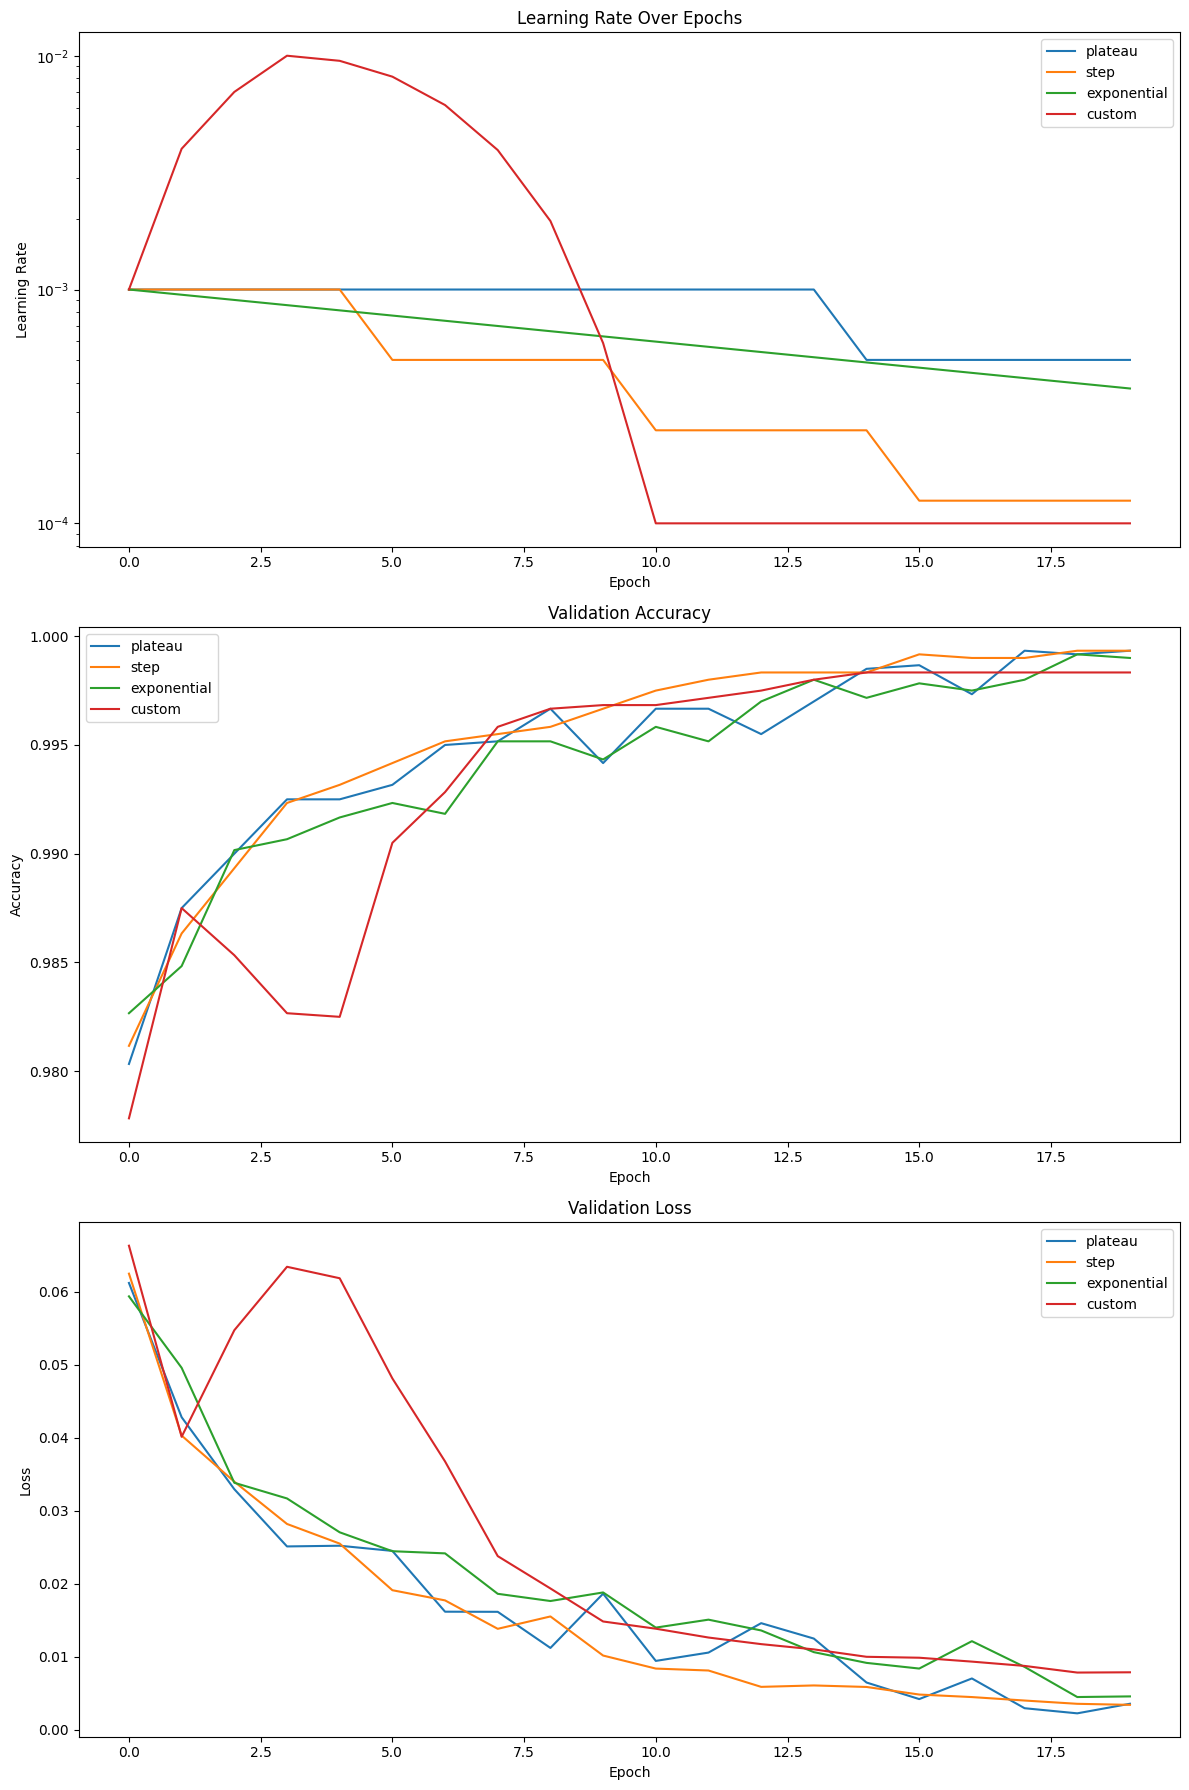


Learning Rate Schedule Comparison:
----------------------------------
Plateau Schedule: Validation Accuracy = 0.9993
Step Schedule: Validation Accuracy = 0.9993
Exponential Schedule: Validation Accuracy = 0.9990
Custom Schedule: Validation Accuracy = 0.9983


In [43]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import cnn_module as cnn
import importlib
importlib.reload(cnn)

# Preprocess the minist dataset
train_data, validation_data, test_data = cnn.preprocess_mnist()

# Define functions for different learning rate schedules

# 1. Step decay schedule
def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=5):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return schedule

# 2. Exponential decay schedule
def exponential_decay_schedule(initial_lr=0.001, decay_rate=0.95):
    def schedule(epoch):
        return initial_lr * (decay_rate ** epoch)
    return schedule

# 3. Custom decay schedule (combining initial warmup with later decay)
def custom_schedule(initial_lr=0.001, max_lr=0.01, min_lr=0.0001, warmup_epochs=3, decay_epochs=7):
    def schedule(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return initial_lr + (max_lr - initial_lr) * (epoch / warmup_epochs)
        else:
            # Cosine decay
            decay_progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + np.cos(np.pi * min(decay_progress, 1.0)))
            return min_lr + (max_lr - min_lr) * cosine_decay
    return schedule

# Create and compile the model (using CNN model from previous implementation)
def create_cnn_model_with_lr(learning_rate=0.001):
    model = keras.Sequential([
        # Same architecture as before
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile with explicit learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Experiment with different learning rate schedules
def train_with_lr_schedule(schedule_type='plateau', initial_lr=0.001, epochs=20):
    # Create a model with specified initial learning rate
    model = create_cnn_model_with_lr(learning_rate=initial_lr)
    
    # Set up callbacks based on schedule type
    callbacks = []
    lr_history = []
    
    # Custom callback to track learning rates
    class LRHistory(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            lr_history.append(self.model.optimizer.lr.numpy())
    
    callbacks.append(LRHistory())
    
    # Add the specific learning rate scheduler
    if schedule_type == 'plateau':
        # ReduceLROnPlateau: reduce learning rate when a metric plateaus
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,       # reduce LR by half
            patience=3,       # wait 3 epochs before reducing
            min_lr=0.00001,   # don't go below this LR
            verbose=1
        )
        callbacks.append(reduce_lr)
        
    elif schedule_type == 'step':
        # Step decay: reduce learning rate after fixed intervals
        lr_scheduler = LearningRateScheduler(
            step_decay_schedule(initial_lr=initial_lr),
            verbose=1
        )
        callbacks.append(lr_scheduler)
        
    elif schedule_type == 'exponential':
        # Exponential decay: continuously reduce learning rate
        lr_scheduler = LearningRateScheduler(
            exponential_decay_schedule(initial_lr=initial_lr),
            verbose=1
        )
        callbacks.append(lr_scheduler)
        
    elif schedule_type == 'custom':
        # Custom schedule with warmup and decay
        lr_scheduler = LearningRateScheduler(
            custom_schedule(initial_lr=initial_lr),
            verbose=1
        )
        callbacks.append(lr_scheduler)

    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping)
    
    # Train the model
    validation_inputs, validation_targets = next(iter(validation_data))
    print(f"\nTraining with {schedule_type} learning rate schedule:")
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=(validation_inputs, validation_targets),
        callbacks=callbacks,
        verbose=2
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    print(f"Test accuracy with {schedule_type} schedule: {test_accuracy:.4f}")
    
    # Return history and learning rates for plotting
    return history, lr_history, model

# Train with different schedules
schedules = ['plateau', 'step', 'exponential', 'custom']
results = {}

for schedule in schedules:
    history, lr_history, model = train_with_lr_schedule(schedule)
    results[schedule] = {
        'history': history,
        'lr_history': lr_history,
        'model': model
    }

# Plot learning rates and results
def plot_lr_comparison(results):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot learning rates
    for schedule, data in results.items():
        ax1.plot(data['lr_history'], label=schedule)
    ax1.set_title('Learning Rate Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_yscale('log')  # Log scale for better visualization
    ax1.legend()
    
    # Plot validation accuracy
    for schedule, data in results.items():
        ax2.plot(data['history'].history['val_accuracy'], label=schedule)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Plot validation loss
    for schedule, data in results.items():
        ax3.plot(data['history'].history['val_loss'], label=schedule)
    ax3.set_title('Validation Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

plot_lr_comparison(results)

# Print final comparison
print("\nLearning Rate Schedule Comparison:")
print("----------------------------------")
for schedule in schedules:
    final_accuracy = results[schedule]['history'].history['val_accuracy'][-1]
    print(f"{schedule.capitalize()} Schedule: Validation Accuracy = {final_accuracy:.4f}")



In [69]:
cnn_exponential_model = results['exponential']['model']

In [75]:
cnn_exponential_model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.02468551>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9941>}

In [73]:
cnn_exponential_model.save('exponential_cnn_model.h5')
print("Model saved in h5 format")

Model saved in h5 format


C:\Users\josep\anaconda3\envs\TF2.0\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Why Learning Rate Scheduling is Beneficial:

1. Better Convergence: Starting with a higher learning rate helps quickly navigate flat regions 
   of the loss landscape, while reducing it later helps fine-tune in steeper areas.

2. Overcoming Plateaus: Adaptive schedules like ReduceLROnPlateau automatically adjust when 
   training metrics stall, helping the model escape local minima.

3. Higher Final Accuracy: Proper learning rate scheduling often leads to better final model 
   performance compared to fixed learning rates.

4. Stability: Gradual reduction of learning rate provides more stable training, avoiding 
   oscillations that can occur with constant high learning rates.

5. Reduced Training Time: Often allows models to converge faster and more efficiently than 
   using a single fixed learning rate throughout training.

Best Practices for MNIST:
- Start with a moderate learning rate (0.001) and reduce it when performance plateaus
- For MNIST, plateau-based scheduling often works well since the dataset is relatively simple
- Custom schedules with warmup periods can be beneficial for more complex models
